In [1]:
from itertools import combinations
import numpy as np
from z3 import *
import utils

In [2]:
def at_least_one_np(bool_vars):
    return Or(bool_vars)

def at_most_one_np(bool_vars, name = ""):
    return [Not(And(pair[0], pair[1])) for pair in combinations(bool_vars, 2)]

def exactly_one_np(bool_vars, name = ""):
    return And(at_least_one_np(bool_vars), And(at_most_one_np(bool_vars, name)))

In [3]:
def at_least_k_np(bool_vars, k, name = ""):
    return at_most_k_np([Not(var) for var in bool_vars], len(bool_vars)-k, name)

def at_most_k_np(bool_vars, k, name = ""):
    return And([Or([Not(x) for x in X]) for X in combinations(bool_vars, k + 1)]) # Naive impl. taking all the combinations

def exactly_k_np(bool_vars, k, name = ""):
    return And(at_most_k_np(bool_vars, k, name), at_least_k_np(bool_vars, k, name))

In [4]:
def vlsi_design(w, n, dims):
    s = Solver()
    upper_bound = sum(dims[:, 1])

    # Model the problem
    v = [[[Bool(f"v_{x}_{y}_{c}") for c in range(n)] for y in range(upper_bound)] for x in range(w)]
    
    # At most one circuit in each grid cell
    for x in range(w):
        for y in range(upper_bound):
            s.add(at_most_one_np(v[x][y], f"valid_cell_{x}_{y}"))
    
    
    if s.check() == sat:
        model = s.model()
        sol = []
        for x in range(w):
            sol.append([])
            for y in range(upper_bound):
                found_circuit = False
                for c in range(n):
                    if model.evaluate(v[x][y][c]):
                        found_circuit = True
                        sol[x].append(c+1)
                if not found_circuit:
                    sol[x].append(0)

        return sol
    else:
        print("Buhu")

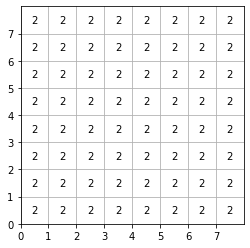

In [5]:
w = 8
n = 4
dims = np.array([[3, 3], [3, 5], [5, 3], [5, 5]])

sol = vlsi_design(w, n, dims)
utils.display_sudoku(sol, w, len(sol))